In [1]:
import pandas as pd
from datetime import datetime, timedelta
from gamma import BayesianGaussianMixture, GaussianMixture
from gamma.utils import convert_picks_csv, association, from_seconds
import numpy as np
from sklearn.cluster import DBSCAN 
from datetime import datetime, timedelta
import os
import json
import pickle
from pyproj import Proj
from tqdm import tqdm

In [2]:
data_dir = lambda x: os.path.join("working", x)
station_csv = data_dir("mexico_stations.csv")
pick_json = data_dir("picks_m3.json")
catalog_csv = data_dir("catalog_gamma.csv")
picks_csv = data_dir("picks_gmma.csv")


if not os.path.exists("figures"):
    os.makedirs("figures")
figure_dir = lambda x: os.path.join("figures", x)

config = {'center': (-95.3516, 16.3274), 
    'xlim_degree': [-99.5665, -91.1368], 
    'ylim_degree': [13.5593, 19.0956], 
    'degree2km': 106.659, 
    'starttime': datetime(2017, 11, 1, 0, 0), 
    'endtime': datetime(2017, 11, 30, 0, 0)}
## read picks
## read picks
picks = pd.read_json(pick_json)
picks["station_id"] = picks["id"]
picks["phase_time"] = picks["timestamp"]
picks["phase_amp"] = picks["amp"]
picks["phase_type"] = picks["type"]
picks["phase_score"] = picks["prob"]


## read stations
stations = pd.read_csv(station_csv, delimiter="\t")
stations = stations.rename(columns={"station":"id"})
proj = Proj(f"+proj=sterea +lon_0={config['center'][0]} +lat_0={config['center'][1]} +units=km")
stations[["x(km)", "y(km)"]] = stations.apply(lambda x: pd.Series(proj(x["longitude"], x["latitude"])), axis=1)
stations["z(km)"] = stations["elevation(m)"].apply(lambda x: -x/1e3)

### setting GMMA configs
config["use_dbscan"] = True
config["use_amplitude"] = True
config["method"] = "BGMM"  
if config["method"] == "BGMM": ## BayesianGaussianMixture
    config["oversample_factor"] = 4
if config["method"] == "GMM": ## GaussianMixture
    config["oversample_factor"] = 1

# earthquake location
config["vel"] = {"p": 6.0, "s": 6.0 / 1.75}
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["x(km)"] = (np.array(config["xlim_degree"])-np.array(config["center"][0]))*config["degree2km"]
config["y(km)"] = (np.array(config["ylim_degree"])-np.array(config["center"][1]))*config["degree2km"]
config["z(km)"] = (0,200)
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 2, config["x(km)"][1] + 2),  # x
    (config["y(km)"][0] - 2, config["y(km)"][1] + 2),  # y
    (0, config["z(km)"][1] + 2),  # z
    (None, None),  # t
)   

## Eikonal for 1D velocity model
# zz = [0.0, 5.5, 16.0, 32.0]
# vp = [5.5, 5.5,  6.7,  7.8]
# vp_vs_ratio = 1.73
# vs = [v / vp_vs_ratio for v in vp]
# h = 0.3
# # h = 3
# vel = {"z": zz, "vp": vp, "vs": vs}
# config["eikonal"] = {"vel": vel, "h": h, "xlim": config["x(km)"], "ylim": config["y(km)"], "zlim": config["z(km)"]}

# DBSCAN
config["dbscan_eps"] = 250 #s
config["dbscan_min_samples"] = 3

# filtering
config["min_picks_per_eq"] = min(5, len(stations) // 2)
config["min_p_picks_per_eq"] = 4
config["min_s_picks_per_eq"] = 2
config["max_sigma11"] = 4.0 # s
config["max_sigma22"] = 1.0 # log10(m/s)
config["max_sigma12"] = 1.0 # covariance

## filter picks without amplitude measurements
if config["use_amplitude"]:
    picks = picks[picks["amp"] != -1]

for k, v in config.items():
    print(f"{k}: {v}")

center: (-95.3516, 16.3274)
xlim_degree: [-99.5665, -91.1368]
ylim_degree: [13.5593, 19.0956]
degree2km: 106.659
starttime: 2017-11-01 00:00:00
endtime: 2017-11-30 00:00:00
use_dbscan: True
use_amplitude: True
method: BGMM
oversample_factor: 4
vel: {'p': 6.0, 's': 3.4285714285714284}
dims: ['x(km)', 'y(km)', 'z(km)']
x(km): [-449.5570191  449.5463532]
y(km): [-295.2427779  295.2534438]
z(km): (0, 200)
bfgs_bounds: ((-451.55701910000005, 451.5463532000012), (-297.2427779000001, 297.2534438), (0, 202), (None, None))
dbscan_eps: 250
dbscan_min_samples: 3
min_picks_per_eq: 5
min_p_picks_per_eq: 4
min_s_picks_per_eq: 2
max_sigma11: 4.0
max_sigma22: 1.0
max_sigma12: 1.0


## 2. Association with GaMMA

In [3]:
event_idx0 = 0 ## current earthquake index
assignments = []
catalogs, assignments = association(picks, stations, config, event_idx0, config["method"])
event_idx0 += len(catalogs)

## create catalog
catalogs = pd.DataFrame(catalogs, columns=["time"]+config["dims"]+["magnitude", "sigma_time", "sigma_amp", "cov_time_amp",  "event_index", "gamma_score"])

# where I keep getting the error 
catalogs[["longitude","latitude"]] = catalogs.apply(lambda x: pd.Series(proj(longitude=x["x(km)"], latitude=x["y(km)"], inverse=True)), axis=1)
catalogs["depth(m)"] = catalogs["z(km)"].apply(lambda x: x*1e3)


with open(catalog_csv, 'w') as fp:
    catalogs.to_csv(fp, sep="\t", index=False, 
                    float_format="%.3f",
                    date_format='%Y-%m-%dT%H:%M:%S.%f',
                    columns=["time", "magnitude", "longitude", "latitude", "depth(m)", "sigma_time", "sigma_amp", "cov_time_amp", "event_index", "gamma_score"])
# catalogs = catalogs[['time', 'magnitude', 'longitude', 'latitude', 'depth(m)', 'sigma_time', 'sigma_amp', 'gamma_score']]

## add assignment to picks
assignments = pd.DataFrame(assignments, columns=["pick_index", "event_index", "gamma_score"])
picks = picks.join(assignments.set_index("pick_index")).fillna(-1).astype({'event_index': int})
with open(picks_csv, 'w') as fp:
    picks.to_csv(fp, sep="\t", index=False, 
                    date_format='%Y-%m-%dT%H:%M:%S.%f',
                    columns=["station_id", "phase_time", "phase_type", "phase_score", "phase_amp", "event_index", "gamma_score"])

Process 12879 picks:   0%|                           | 0/160607 [00:00<?, ?it/s]/Users/marcgarcia/opt/anaconda3/lib/python3.9/site-packages/gamma/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
Process 6833 picks:  12%|█▋            | 19712/160607 [37:13<4:26:03,  8.83it/s]/Users/marcgarcia/opt/anaconda3/lib/python3.9/site-packages/gamma/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
Process 6358 picks:  16%|██▎           | 26070/160607 [47:01<3:57:27,  9.44it/s]/Users/marcgarcia/opt/anaconda3/lib/python3.9/site-packages/gamma/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for d

# 3. Visualize the results

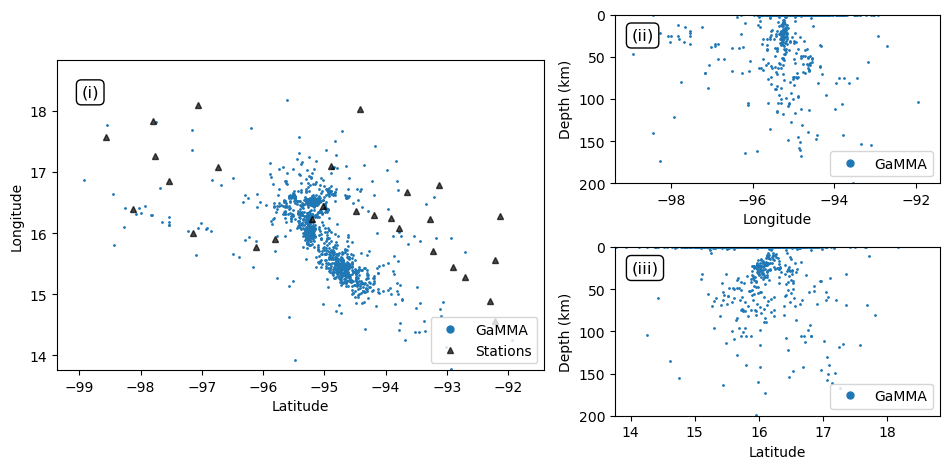

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

result_label="GaMMA"
catalog_label="SCSN"


stations = pd.read_csv(data_dir("mexico_stations.csv"), delimiter="\t")
#events = pd.read_csv(data_dir("events.csv"), delimiter="\t")
#events["time"] = events["time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f"))

catalog = pd.read_csv(data_dir("catalog_gamma.csv"), delimiter="\t")
catalog["time"] = catalog["time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f"))



fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([1.5,1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.92]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1,1])
fig.add_subplot(grd[:, 0])
plt.plot(catalog["longitude"], catalog["latitude"], '.',markersize=2, alpha=1.0)
#plt.plot(events["longitude"], events["latitude"], '.', markersize=2, alpha=0.6)
plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"])+np.array([0.2,-0.27]))
plt.ylim(np.array(config["ylim_degree"])+np.array([0.2,-0.27]))
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, config["ylim_degree"][0]-10, '.', markersize=10, label=f"{result_label}", rasterized=True)
#plt.plot(config["xlim_degree"][0]-10, config["ylim_degree"][0]-10, '.', markersize=10, label=f"{catalog_label}", rasterized=True)
plt.plot(stations["longitude"], stations["latitude"], 'k^', markersize=5, alpha=0.7, label="Stations")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[0, 1])
plt.plot(catalog["longitude"], catalog["depth(m)"]/1e3, '.', markersize=2, alpha=1.0, rasterized=True)
#plt.plot(events["longitude"], events["depth(m)"]/1e3, '.', markersize=2, alpha=0.6, rasterized=True)
# plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"])+np.array([0.2,-0.27]))
plt.ylim([0,200])
plt.gca().invert_yaxis()
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, 31, '.', markersize=10, label=f"{result_label}")
#plt.plot(31, 31, '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[1, 1])
plt.plot(catalog["latitude"], catalog["depth(m)"]/1e3, '.', markersize=2, alpha=1.0, rasterized=True)
#plt.plot(events["latitude"], events["depth(m)"]/1e3, '.', markersize=2, alpha=0.6, rasterized=True)
# plt.axis("scaled")
plt.xlim(np.array(config["ylim_degree"])+np.array([0.2,-0.27]))
plt.ylim([0,200])
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["ylim_degree"][0]-10, 31, '.', markersize=10, label=f"{result_label}")
#plt.plot(31, 31, '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.savefig(figure_dir("earthquake_location.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("earthquake_location.pdf"), bbox_inches="tight", dpi=300)
plt.show();